# Exploratory Data Analysis

This file contains the code for question 1 of task 1 of project 1 in Machine Learning for Healthcare offered at ETH Zurich in FS2024

## Packages and Presets

In [4]:
import numpy as np
import pandas as pd
import plotnine as pn
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from skimpy import skim, clean_columns
import scipy.stats as stats
# robust covariance estimator:
from sklearn.covariance import MinCovDet
from sklearn.ensemble import IsolationForest
from pca import pca

from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore") #sanest python user

%matplotlib inline

## Basic Summary Statistics

In [5]:
# Loading the data:
heart_failure = pd.read_csv('data/heart_failure/train_val_split.csv')
# get shape of dataframe
print(heart_failure.shape)
# get first 5 rows of dataframe
heart_failure.head()

(734, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [6]:
# check for duplicate rows
print(heart_failure.duplicated().any())

False


Thus, our training (and validation) data consists of 734 observations with 12 columns. There are no duplicate rows or columns. However, the column names involve lower and upper case letters which is usually not desired. Thus, we will first clean the column names and then have a quick look at the data set:

In [7]:
# clean column names
heart_failure = clean_columns(heart_failure)

# get number of unique values in each column
unique_values = heart_failure.nunique()
print(unique_values)

age                 49
sex                  2
chest_pain_type      4
resting_bp          64
cholesterol        204
fasting_bs           2
resting_ecg          3
max_hr             115
exercise_angina      2
oldpeak             50
st_slope             3
heart_disease        2
dtype: int64


Hence, we are working with the following columns (see [here](https://www.sciencedirect.com/science/article/pii/S2772442522000703) for more information about variables):

- age: age of the patient in years
- sex: sex of the patient
- chest_pain_type: chest pain type of the patient
- resting_bp: resting blood pressure of the patient
- cholesterol: cholesterol level of patient
- fasting_bs: fasting blood sugar of patient
- resting_ecg: resting electrocardiagram type of patient
- max_hr: maximum heart rate of patient
- exercise_angina: wheter patient has exercise induced angina or not
- oldpeak: depression of ST segment during exercise vs at rest in ecg
- st_slope: slope direction of the ST segment in ecg
- heart_disease: whether patient has heart disease or not

Moreover, we can see that many of our predictors are factor variables. Additionally, our response "heart_disease" is also a binary variable. Let's further investigate these factor variables:

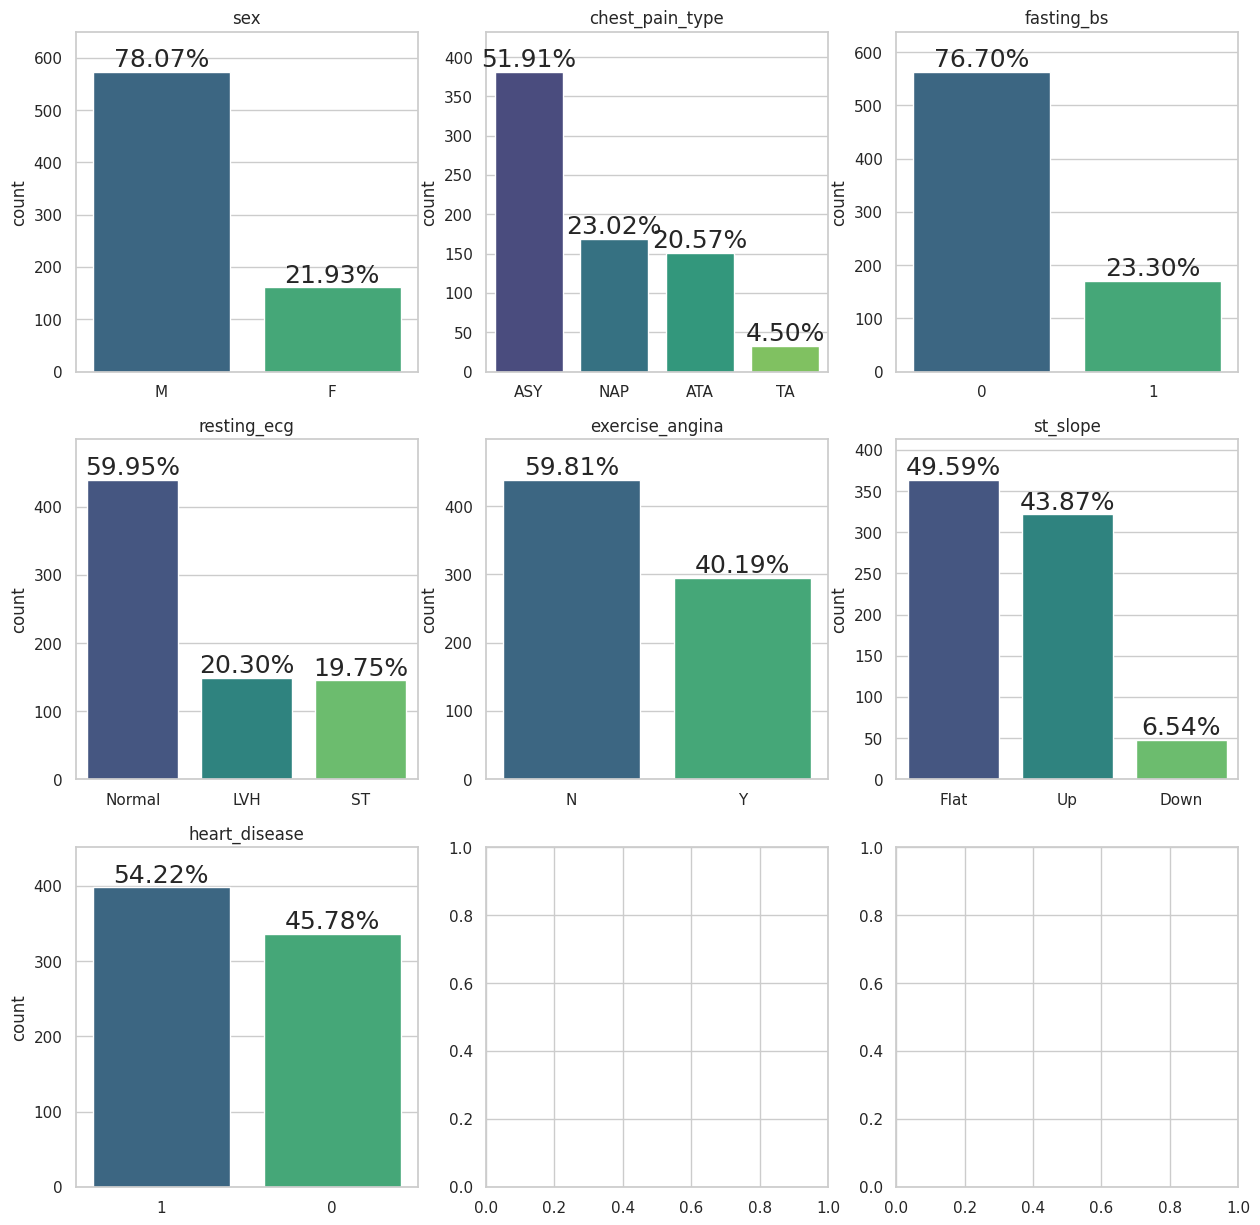

In [49]:
# get list of columns with less than 5 unique values
factor_cols = [col for col in heart_failure.columns if unique_values[col] < 5]

n_cols = 3
n_rows = int(len(factor_cols)/n_cols) + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(factor_cols):
    
    ax = axs[i]
    
    # order the bars
    order = heart_failure[col].value_counts().index
    sns.countplot(
        data=heart_failure, x=col, ax=ax, order=order,
        palette='viridis', width = 0.8
    )
    
    # remove legend
    ax.legend([],[], frameon=False)
    # remove x label
    ax.set_xlabel('')
    # set title to column name
    ax.set_title(col)
    # adding percentages
    # see https://stackoverflow.com/questions/76240680/how-do-i-add-a-percentage-to-a-countplot
    ax.bar_label(ax.containers[0], fmt=lambda x: f"{x/heart_failure.shape[0] * 100:.2f}%")
    ax.set_ylim(0, ax.get_ylim()[1] * 1.08)

We can see that there are severe class imbalances in most of the featurues but not in the response variable (heart_disease). We will thus proceed without any resamplin or oversampling (e.g. SMOTE) and only apply dummy encoding to the features as class imbalances in the features (and not the response) are usually not concerning. Nevertheless, when interpreting our results in the end we have to keep in mind that we only had very few female training data.

Let's move on to the numeric columns. First, we have a look at some summary statistics and at the number and location of NA observations in our dataframe:

In [9]:
# some summary statistics:
skim(heart_failure)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 734    │ │ int64       │ 6     │                                                          │
│ │ Number of columns │ 12     │ │ string      │ 5     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ age                 │    0 │       0 │      54 │     9.4 │   29 │    47 │    54 │    60 │     77 │ ▁▃▅▇▅▁  │  │
│ │ resting_bp          │    0 │       0 │     130 │      19 │    0 │   120 │   130 │   140 │    200 │    ▇▆▁  │  │
│ │ cholesterol         │    0 │       0 │     200 │     110 │    0 │   170 │   220 │   270 │    530 │  ▃▁▇▃   │  │
│ │ fasting_bs          │    0 │       0 │    0.23 │    0.42 │    0 │     0 │     0 │     0 │      1 │ ▇    ▂  │  │
│ │ max_hr              │    0 │       0 │     140 │      25 │   60 │   120 │   140 │   160 │    200 │ ▁▂▇▇▇▂  │  │
│ │ oldpeak             │    0 │       0 │    0.87 │     1.1 │   -2 │     0 │   0.5 │   1.5 │    6.2 │   ▇▅▁   │  │
│ │ heart_disease       │    0 │       0 │    0.54 │     0.5 │    0 │     0 │     1 │     1 │      1 │ ▇    ▇  │  │
│ └─────────────────────┴──────┴─────────┴─────────┴─────────┴──────┴───────┴───────┴───────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                     ┃ NA     ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ sex                             │      0 │          0 │                          1 │                   734 │  │
│ │ chest_pain_type                 │      0 │          0 │                          1 │                   734 │  │
│ │ resting_ecg                     │      0 │          0 │                          1 │                   734 │  │
│ │ exercise_angina                 │      0 │          0 │                          1 │                   734 │  │
│ │ st_slope                        │      0 │          0 │                          1 │                   734 │  │
│ └─────────────────────────────────┴────────┴────────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Thus, we are working with seven numeric columns, where fasting_bs (fasting blood sugar) and heart_disease are dummy variables, and five columns involving strings. It is evident, that all numeric features apart from oldpeak are non-negative where a total of 11 observations have a negative oldpeak value (see below). Moreover, we can see that at least one patient has a cholesterol level of 0 and at least one patient has a resting blood pressure of 0, which is impossible. 

 <span style="color:red">Double check negative values!</span>


In [10]:
heart_failure.query('oldpeak <0')

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
259,63,M,ASY,100,0,1,Normal,109,N,-0.9,Flat,1
261,42,M,ASY,105,0,1,Normal,128,Y,-1.5,Down,1
262,45,M,NAP,110,0,0,Normal,138,N,-0.1,Up,0
266,56,M,ASY,115,0,1,ST,82,N,-1.0,Up,1
267,51,M,ASY,130,0,1,Normal,170,N,-0.7,Up,1
268,62,M,TA,120,0,1,LVH,134,N,-0.8,Flat,1
281,56,M,ASY,120,0,0,ST,100,Y,-1.0,Down,1
330,62,M,ASY,115,0,1,Normal,72,Y,-0.5,Flat,1
335,56,M,NAP,125,0,1,Normal,98,N,-2.0,Flat,1
342,66,M,NAP,120,0,0,ST,120,N,-0.5,Up,0


Hence, we have 11 observations with negative oldpeak. We can see that 10 of those 11 patients also have a cholesterol level of 0. Thus, it is possible that missing values in cholesterol have been filled with 0.

In [11]:
heart_failure.query('cholesterol == 0').describe()

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,heart_disease
count,141.000000,141.000000,141.0,141.000000,141.000000,141.000000,141.000000
mean,56.361702,129.780142,0.0,0.496454,122.070922,0.809220,0.886525
std,8.727851,22.761839,0.0,0.501770,24.776903,1.027542,0.318304
min,34.000000,0.000000,0.0,0.000000,60.000000,-2.000000,0.000000
25%,51.000000,120.000000,0.0,0.000000,108.000000,0.000000,1.000000
50%,57.000000,130.000000,0.0,0.000000,120.000000,0.700000,1.000000
75%,62.000000,140.000000,0.0,1.000000,140.000000,1.500000,1.000000
max,74.000000,200.000000,0.0,1.000000,182.000000,3.700000,1.000000


In [12]:
heart_failure.query('cholesterol != 0').describe()

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,heart_disease
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,52.848229,132.605396,244.569983,0.170320,139.519393,0.889376,0.460371
std,9.460831,17.468585,56.529282,0.376231,24.309450,1.095093,0.498848
min,29.000000,94.000000,85.000000,0.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,208.000000,0.000000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,238.000000,0.000000,140.000000,0.400000,0.000000
75%,59.000000,140.000000,276.000000,0.000000,159.000000,1.500000,1.000000
max,77.000000,200.000000,529.000000,1.000000,195.000000,6.200000,1.000000


In [13]:
heart_failure.query('resting_bp == 0')

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
366,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


age                0
sex                0
chest_pain_type    0
resting_bp         0
cholesterol        0
fasting_bs         0
resting_ecg        0
max_hr             0
exercise_angina    0
oldpeak            0
st_slope           0
heart_disease      0
dtype: int64


<Axes: >

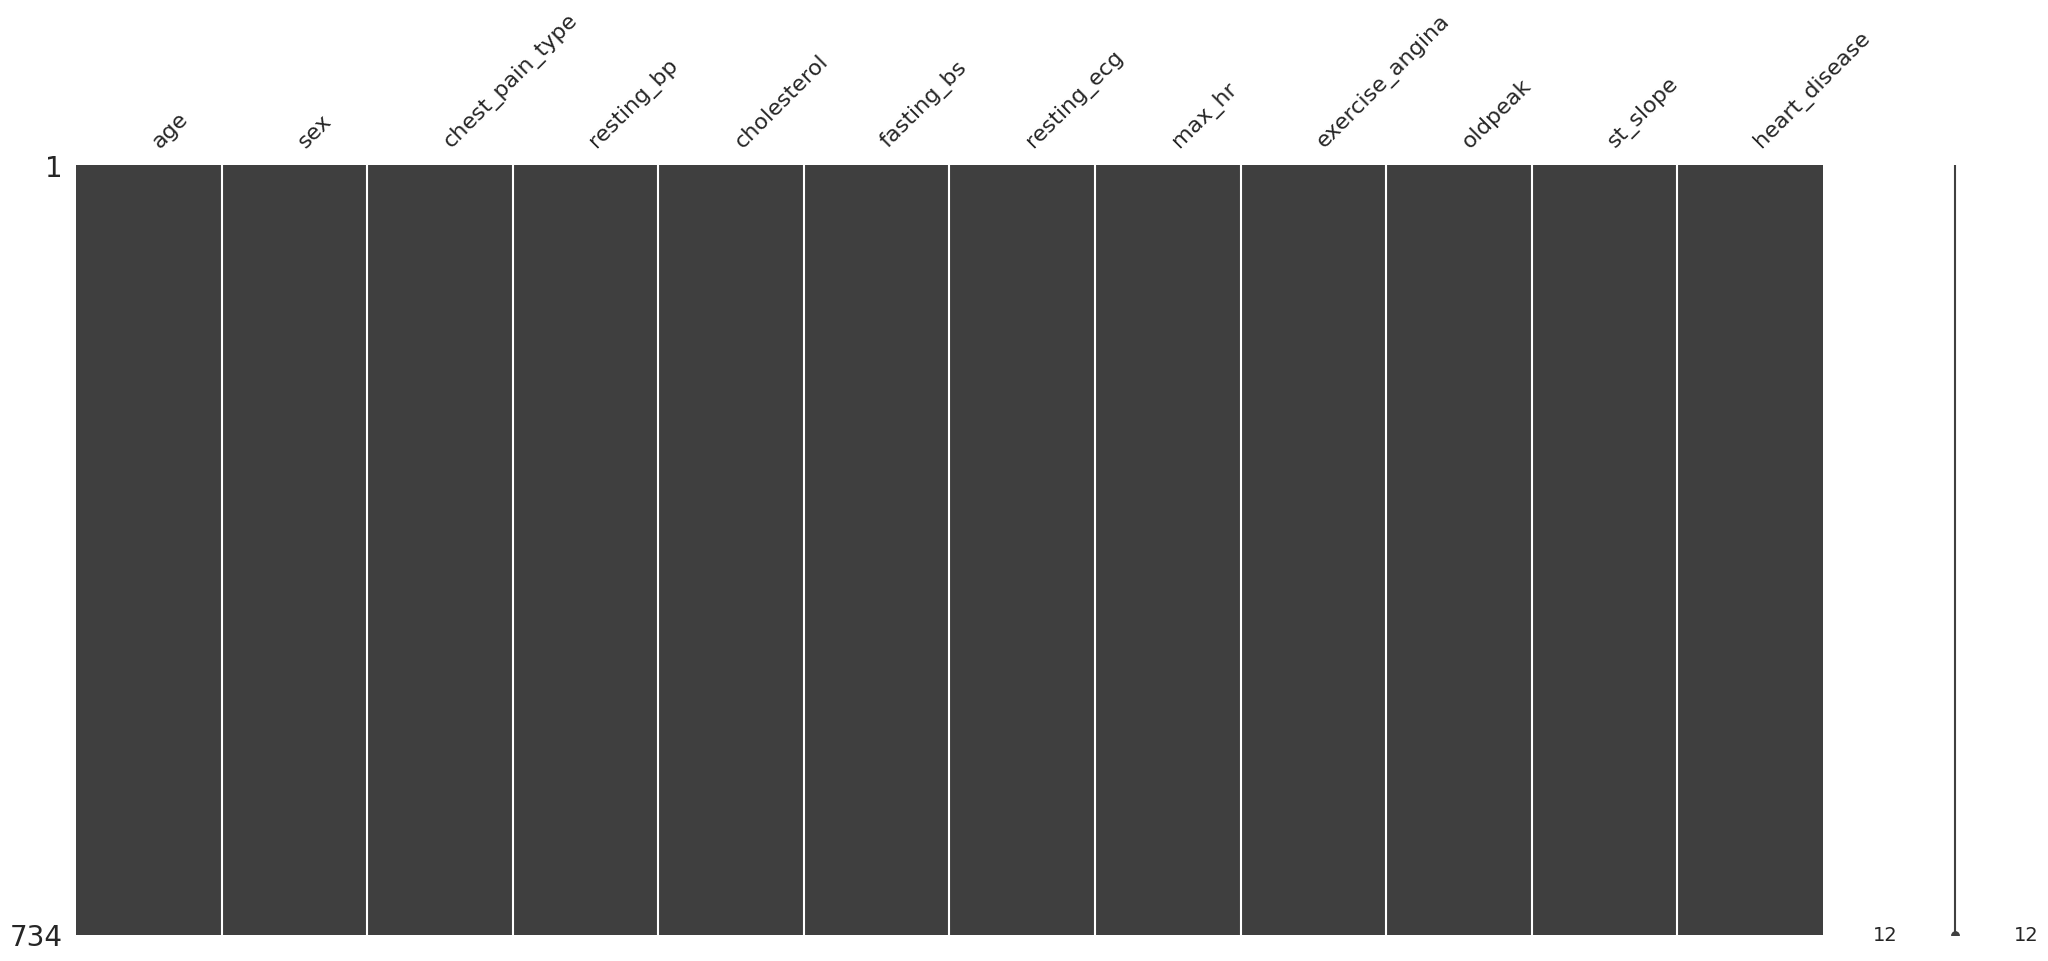

In [14]:
# count missing values
print(heart_failure.isna().sum())
# plot missing values/NAs
msno.matrix(heart_failure)

Luckily, we do not have any NAs in our dataset. We continue by investigating the distributions of the different numeric features

## Pair Plots

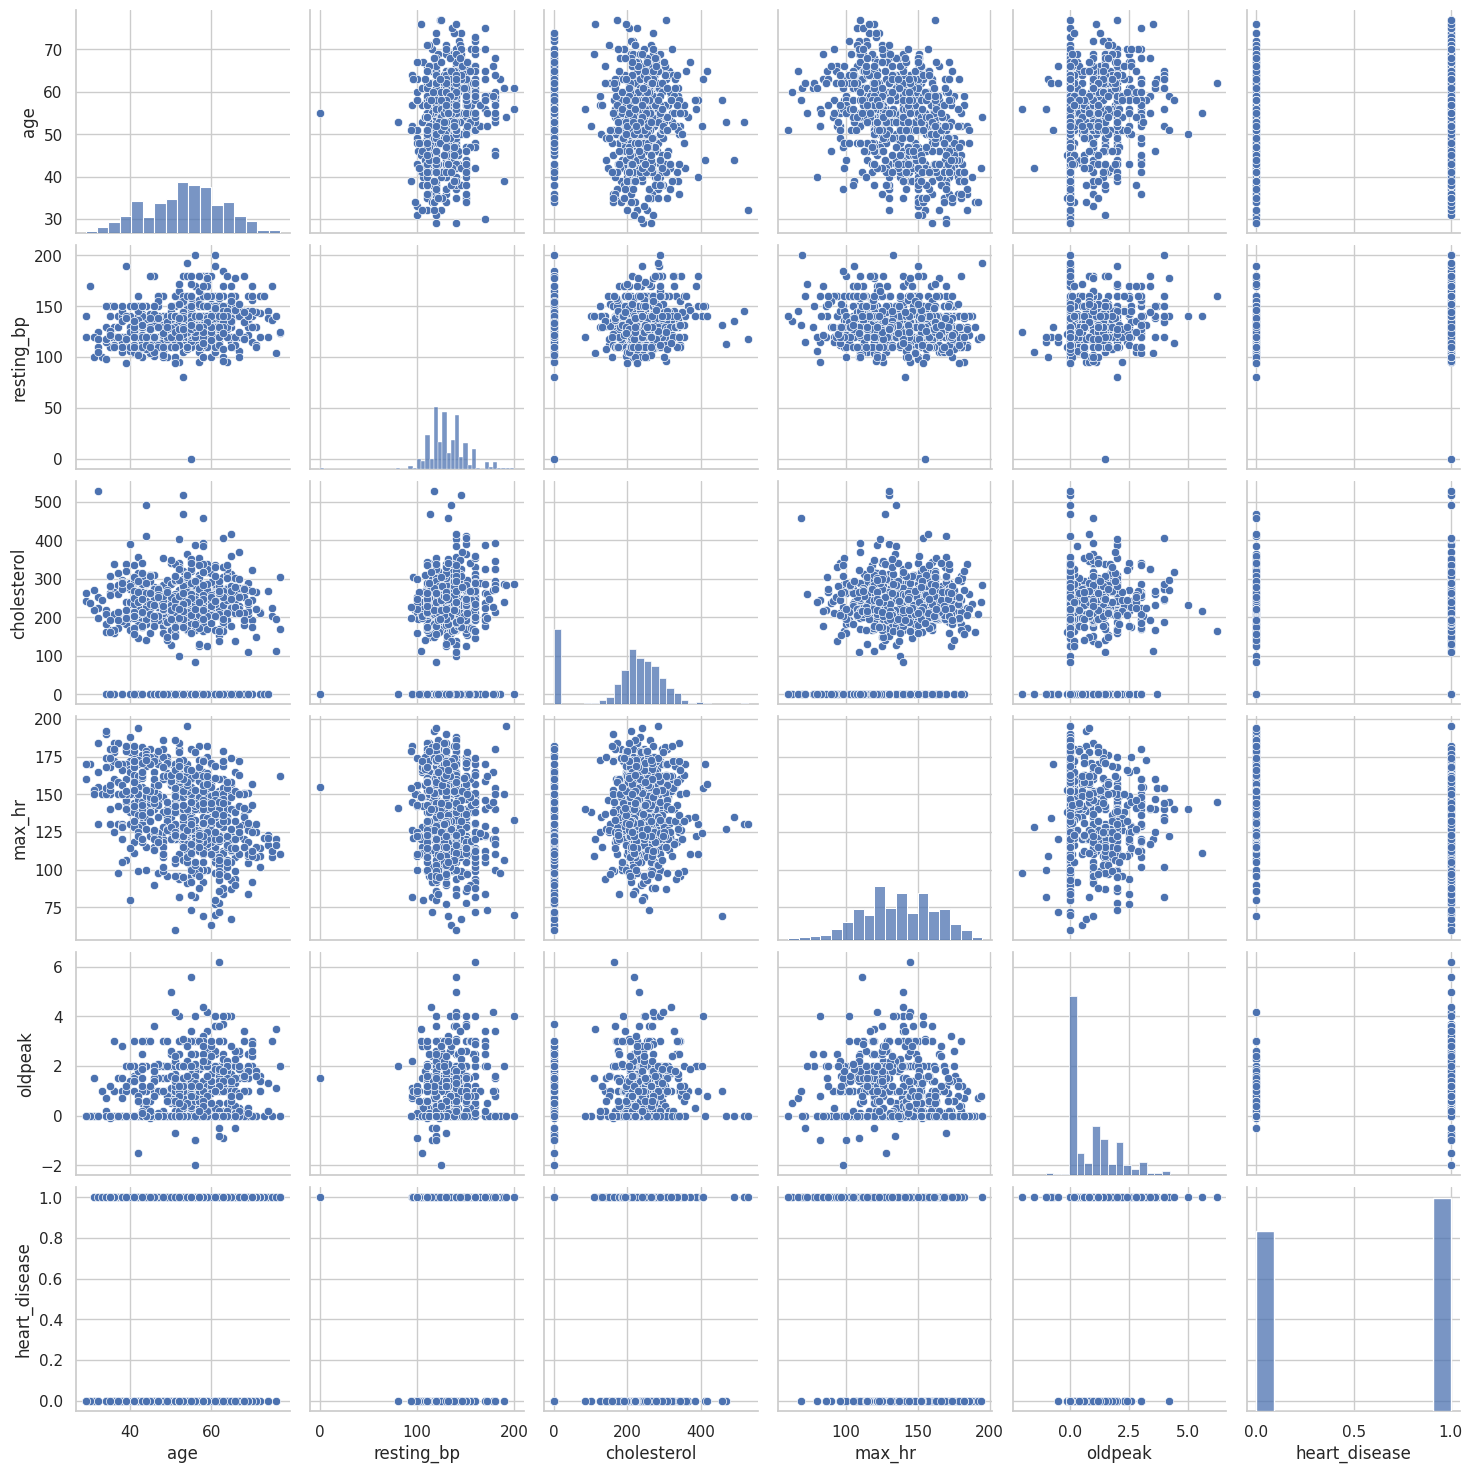

In [15]:
# pairplot of all numeric columns colored by sex
sns.pairplot(
    heart_failure[['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'heart_disease']],
    #diag_kind='kde'
)

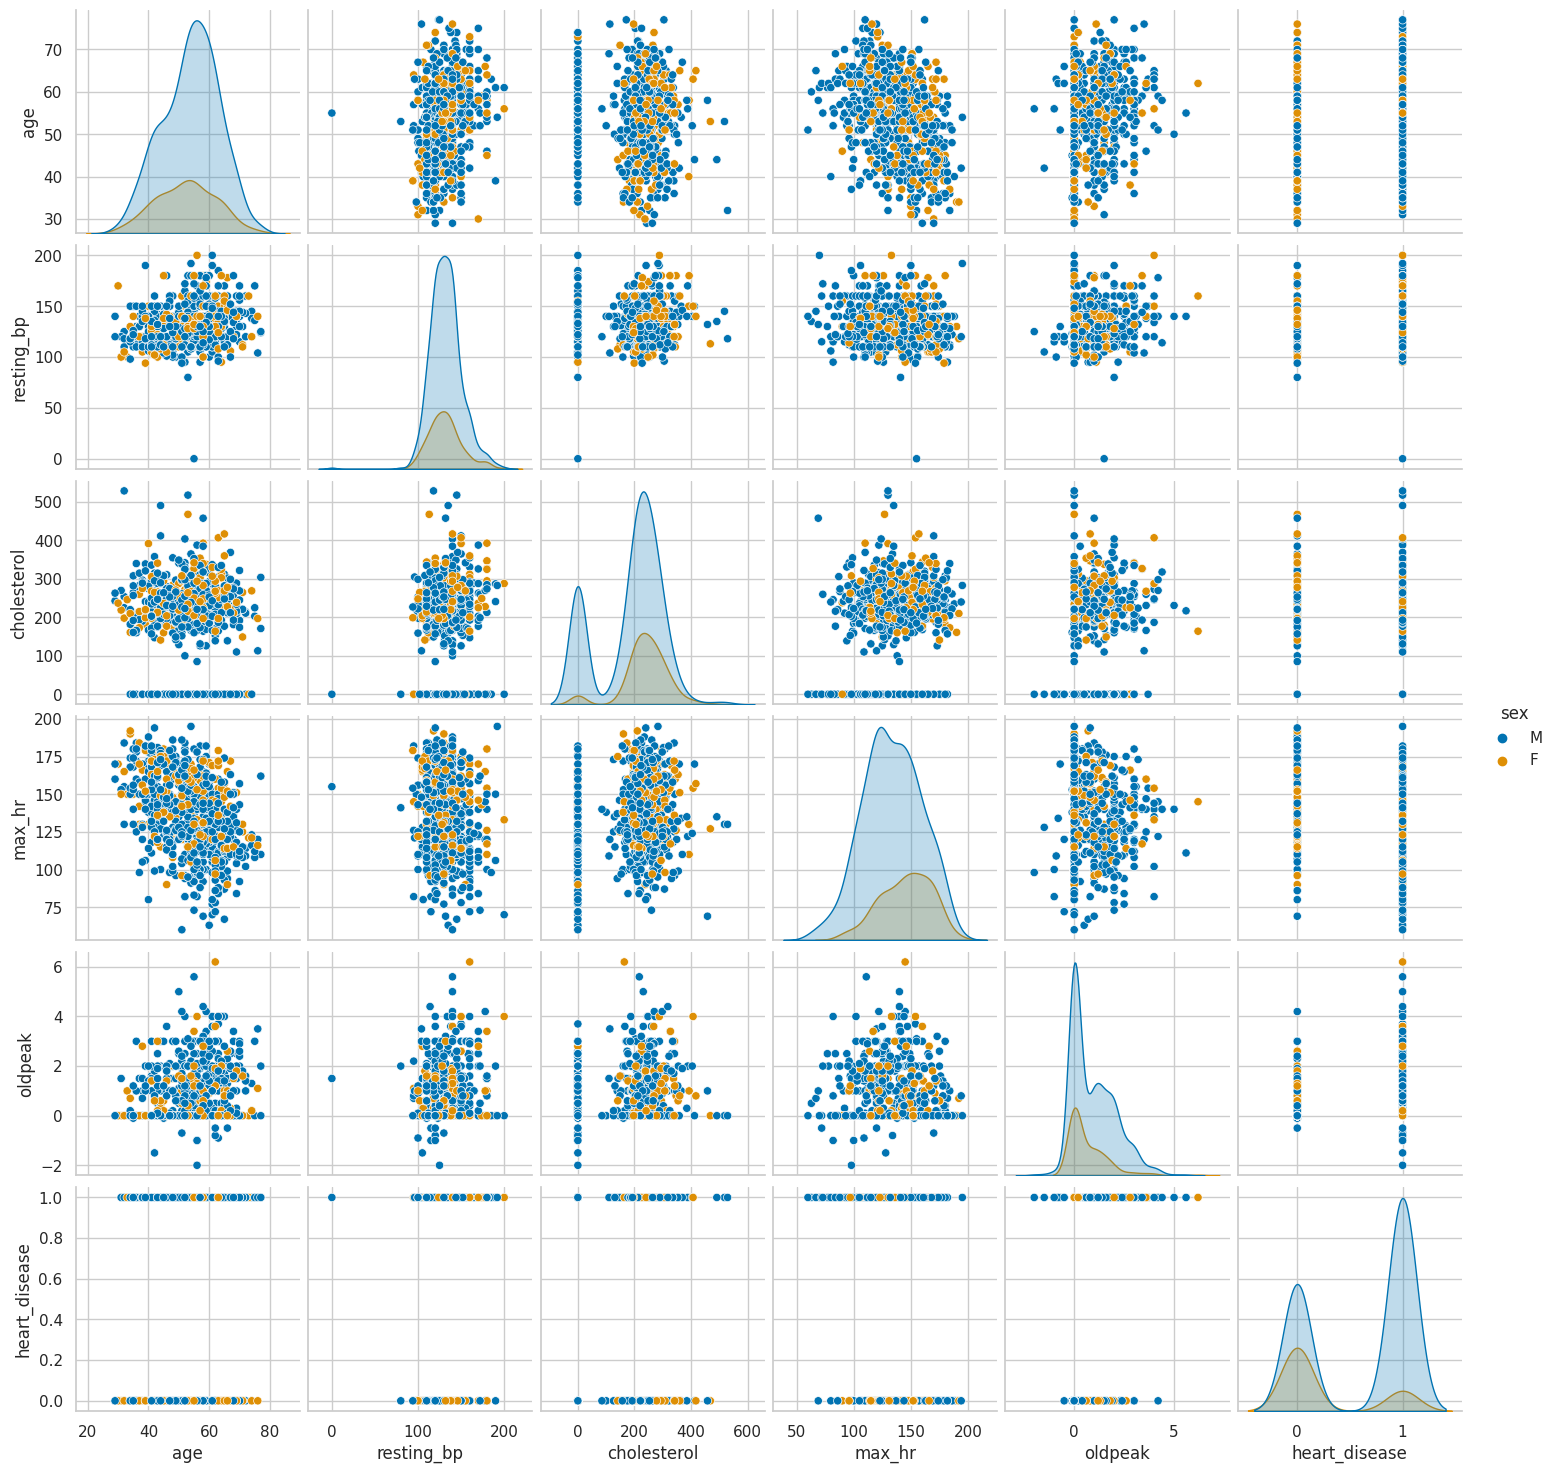

In [16]:
# pairplot of all numeric columns colored by sex
sns.pairplot(
    heart_failure[['sex','age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'heart_disease']],
    diag_kind='kde',
    hue= 'sex',
    palette='colorblind'
)

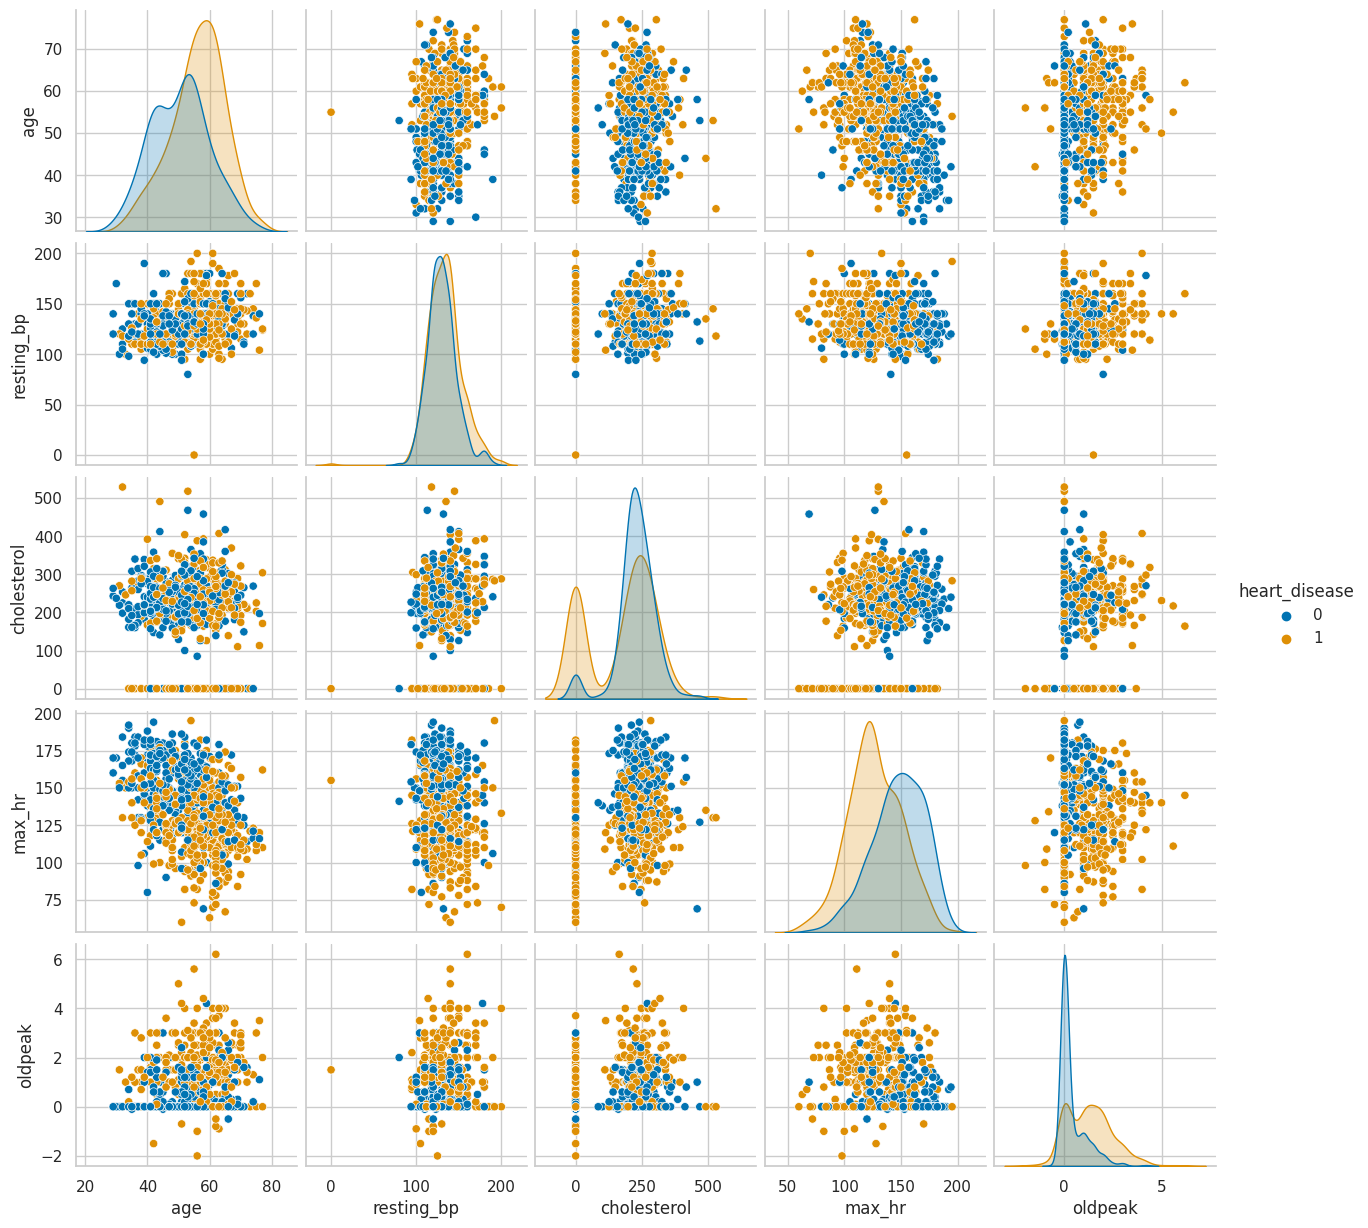

In [17]:
# pairplot of all numeric columns colored by heart_disease
sns.pairplot(
    heart_failure[['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak', 'heart_disease']],
    diag_kind='kde',
    hue= 'heart_disease',
    palette='colorblind'
)

### Correlation Analysis

<Axes: >

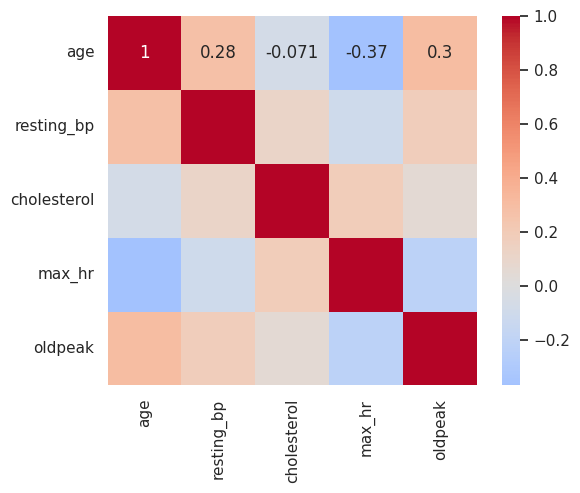

In [18]:
# correlation plot
corr = (
    heart_failure.iloc[:, ~heart_failure.columns.isin(factor_cols)]
    # use spearman due to zero-inflated data and non-negativity of most variables
    .corr(method='spearman')
)

sns.heatmap(corr, cmap='coolwarm', center=0, square=True, annot=True)

<Figure size 1500x1500 with 0 Axes>

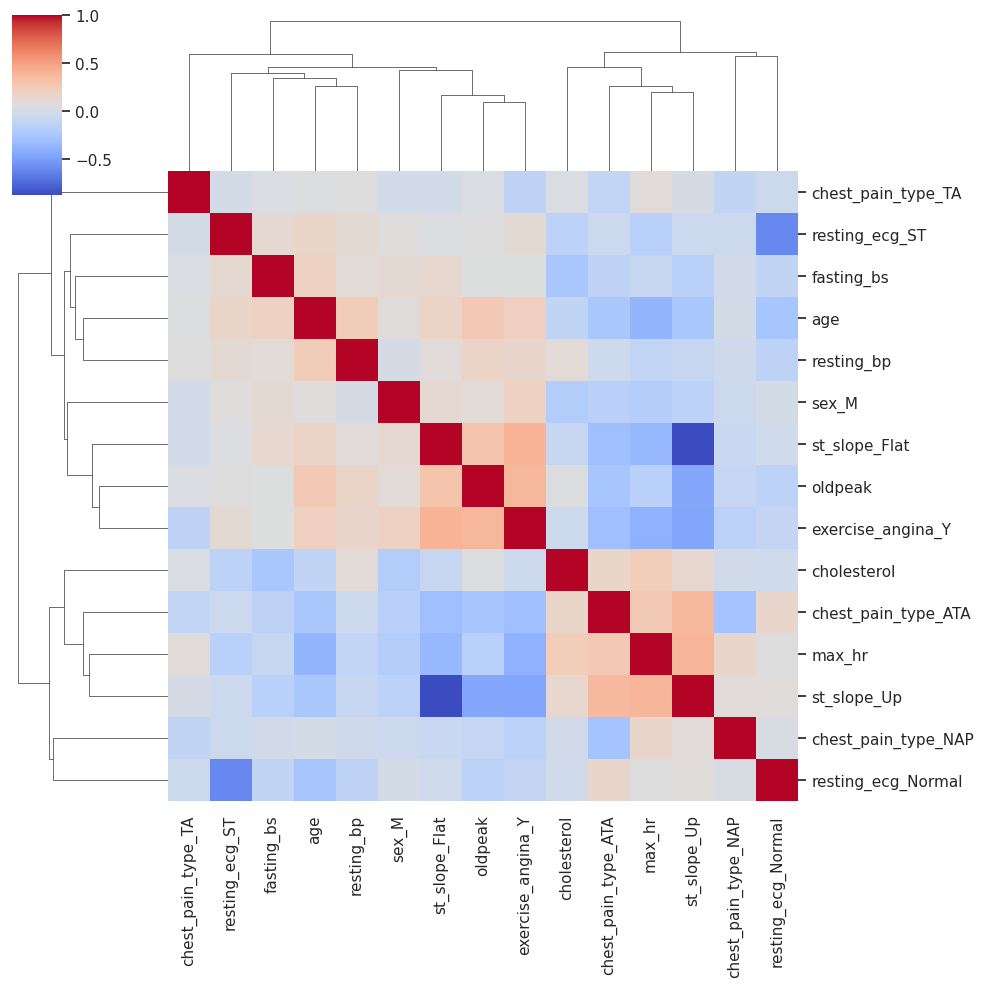

<Figure size 1500x1500 with 0 Axes>

In [19]:
dummies_hd = pd.get_dummies(heart_failure.drop('heart_disease', axis=1), drop_first = True)
sns.clustermap(dummies_hd.corr(), cmap='coolwarm', annot=False)
plt.figure(figsize=(15, 15))

## Outliers

### Univariate Outliers

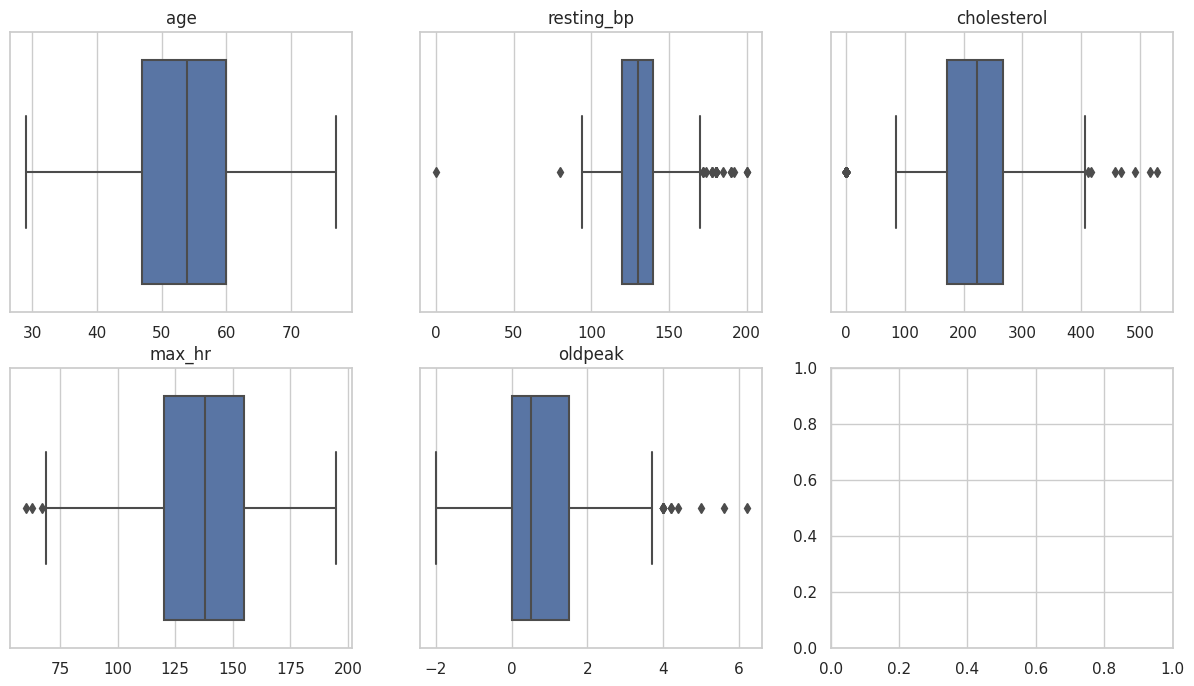

In [20]:
numeric_cols = ['age', 'resting_bp', 'cholesterol', 'max_hr', 'oldpeak']

n_cols = 3
n_rows = np.ceil(len(numeric_cols)/3).astype(int)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    
    ax = axs[i]
    
    
    sns.boxplot(
        data=heart_failure, x=col, ax=ax
    )
    
    
    # remove legend
    ax.legend([],[], frameon=False)
    # remove x label
    ax.set_xlabel('')
    # set title to column name
    ax.set_title(col)

### Multivariate Outliers

First, let's have a look at the squared Mahalanobis distance:

Text(0.5, 1.0, 'Chi-square plot')

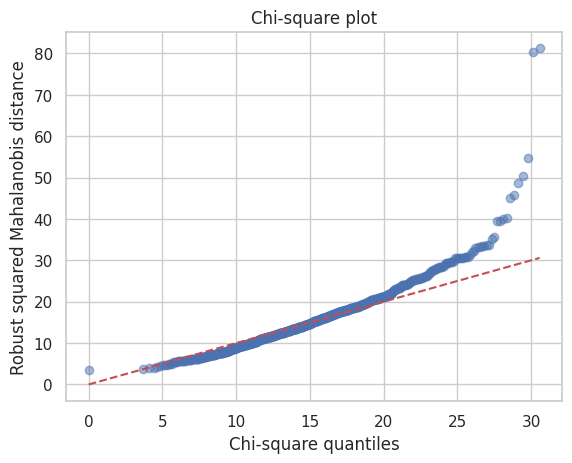

In [21]:
# this implementation is inspired by the code for the chisq.plot function in
# the mvoutlier R package see: 
# https://github.com/cran/mvoutlier/blob/master/R/chisq.plot.R

# fit robust covariance estimator
mcd = MinCovDet().fit(dummies_hd)
# calculate squared Mahalanobis distance
squared_mahal_dist = mcd.mahalanobis(dummies_hd) #** 2
sorted_squared_mahal_dist = np.sort(squared_mahal_dist)

dof = dummies_hd.shape[1]
quantiles = np.linspace(0., 0.99, len(sorted_squared_mahal_dist))
chi2_quantiles = stats.chi2.ppf(quantiles, dof)

plt.plot(chi2_quantiles, sorted_squared_mahal_dist, 'o', alpha=0.5)
plt.plot(chi2_quantiles, chi2_quantiles, 'r--')
plt.xlabel('Chi-square quantiles')
plt.ylabel('Robust squared Mahalanobis distance')
plt.title('Chi-square plot')

In [22]:
dummies_hd.iloc[np.where(squared_mahal_dist > 40)[0],:]

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,sex_M,chest_pain_type_ATA,chest_pain_type_NAP,chest_pain_type_TA,resting_ecg_Normal,resting_ecg_ST,exercise_angina_Y,st_slope_Flat,st_slope_Up
260,38,105,0,1,166,2.8,False,False,False,False,True,False,False,False,True
270,63,150,0,1,154,3.7,True,False,False,False,False,True,False,False,True
323,61,200,0,1,70,0.0,True,False,True,False,False,True,False,True,False
366,55,0,0,0,155,1.5,True,False,True,False,True,False,False,True,False
440,76,104,113,0,120,3.5,True,False,True,False,False,False,False,False,False
565,59,178,270,0,145,4.2,True,False,False,True,False,False,False,False,False
588,56,200,288,1,133,4.0,False,False,False,False,False,False,True,False,False
624,55,140,217,0,111,5.6,True,False,False,False,True,False,True,False,False
681,62,160,164,0,145,6.2,False,False,False,False,False,False,False,False,False


In [23]:
## outlier detection using isolation forest
iso_forest = IsolationForest(random_state=42, contamination=0.05)

iso_forest.fit(dummies_hd)
outliers = iso_forest.predict(dummies_hd)
outliers_idx = np.where(outliers == -1)[0]

dummies_hd.iloc[outliers_idx,:]

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,sex_M,chest_pain_type_ATA,chest_pain_type_NAP,chest_pain_type_TA,resting_ecg_Normal,resting_ecg_ST,exercise_angina_Y,st_slope_Flat,st_slope_Up
33,48,120,177,1,148,0.0,False,True,False,False,False,True,False,False,True
74,43,120,291,0,155,0.0,True,False,False,True,False,True,False,True,False
100,58,180,393,0,110,1.0,False,True,False,False,True,False,True,True,False
134,46,140,272,1,175,2.0,True,False,False,True,True,False,False,True,False
162,57,130,308,0,98,1.0,False,False,False,True,True,False,False,True,False
176,30,170,237,0,170,0.0,False,False,False,True,False,True,False,False,True
244,62,120,0,1,123,1.7,False,False,False,False,False,True,True,False,False
246,51,120,0,1,127,1.5,False,False,False,False,True,False,True,False,True
254,74,145,0,1,123,1.3,True,True,False,False,False,True,False,False,True
260,38,105,0,1,166,2.8,False,False,False,False,True,False,False,False,True


In [24]:
?pca

Init signature:
pca(
    n_components=0.95,
    n_feat=25,
    method='pca',
    alpha=0.05,
    multipletests='fdr_bh',
    n_std=3,
    onehot=False,
    normalize=False,
    detect_outliers=['ht2', 'spe'],
    random_state=None,
    verbose='info',
)
Docstring:     
pca module.

Parameters
----------
n_components : [0..1] or [1..number of samples-1], (default: 0.95)
    Number of PCs to be returned. When n_components is set >0, the specified number of PCs is returned.
    When n_components is set between [0..1], the number of PCs is returned that covers at least this percentage of variance.
    n_components=None : Return all PCs
    n_components=0.95 : Return the number of PCs that cover at least 95% of variance.
    n_components=3    : Return the top 3 PCs.
n_feat : int, default: 10
    Number of features that explain the space the most, dervied from the loadings. This parameter is used for vizualization purposes only.
method : 'pca' (default)
    'pca' : Principal Component Analys

In [25]:
# See https://towardsdatascience.com/outlier-detection-using-principal-component-analysis-and-hotellings-t2-and-spe-dmodx-methods-625b3c90897
# for more info about outlier detection using pca
X_dummies = pd.get_dummies(heart_failure.drop('heart_disease', axis=1), drop_first = True)

pca_model = pca(normalize=True, random_state=42)
pca_res = pca_model.fit_transform(X_dummies)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [15] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [15] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[13]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Add density layer


[pca] >Plot PC1 vs PC2 with loadings.


[scatterd] >INFO> Create scatterplot


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': 'Outliers marked using Hotellings T2 method.'}, xlabel='PC1 (22.9% expl.var)', ylabel='PC2 (11.2% expl.var)'>)

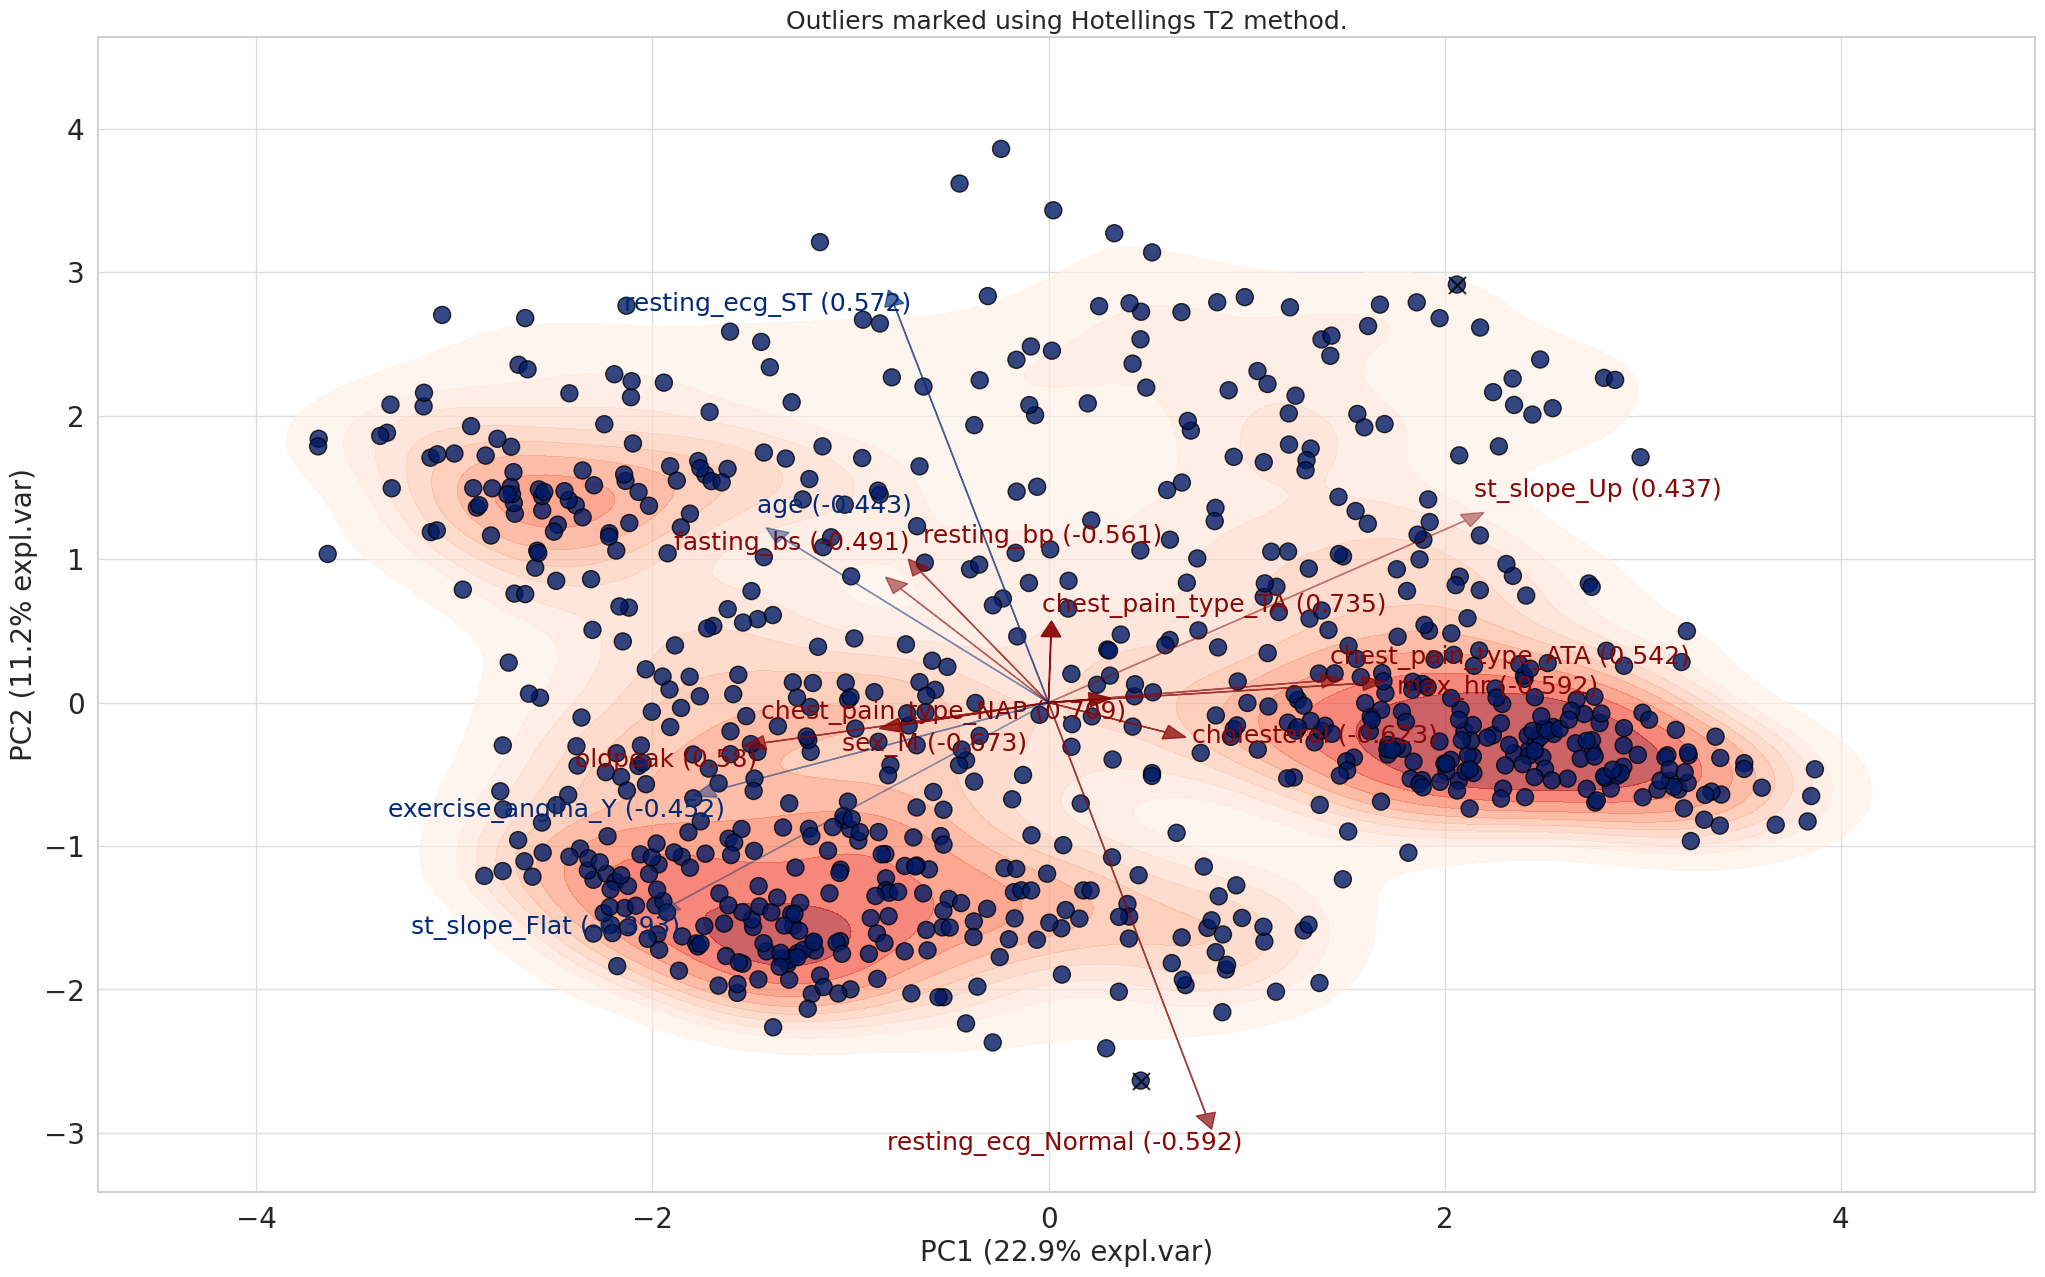

In [26]:
pca_model.biplot(SPE=False, HT2=True, density=True, title='Outliers marked using Hotellings T2 method.')

In [27]:
print(f"Number of Outliers according to PCA using Hotelling's T: {np.sum(pca_res['outliers']['y_bool'])}")
outlier_mask = pca_res['outliers']['y_bool']
X_dummies[outlier_mask]

Number of Outliers according to PCA using Hotelling's T: 2


,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,sex_M,chest_pain_type_ATA,chest_pain_type_NAP,chest_pain_type_TA,resting_ecg_Normal,resting_ecg_ST,exercise_angina_Y,st_slope_Flat,st_slope_Up
176,30,170,237,0,170,0.0,False,False,False,True,False,True,False,False,True
366,55,0,0,0,155,1.5,True,False,True,False,True,False,False,True,False


In [28]:
pca_res['outliers']

,y_proba,p_raw,y_score,y_bool,y_bool_spe,y_score_spe
0,0.980987,0.635523,22.954442,False,False,3.146791
1,0.980987,0.175682,32.545947,False,False,2.546220
2,0.980987,0.752371,20.796889,False,False,2.057425
3,0.980987,0.814279,19.508043,False,False,1.260302
4,0.980987,0.474375,25.795753,False,False,2.847728
...,...,...,...,...,...,...
729,0.980987,0.608036,23.438547,False,False,3.249179
730,0.980987,0.758439,20.676990,False,False,1.606755
731,0.650865,0.028376,41.384839,False,False,1.312841
732,0.980987,0.349996,28.173053,False,False,2.110850


## Preprocessing for Further Tasks:

This explanatory data analysis suggests the following preprocessing procedure for the upcoming tasks:
- clean the column names (e.g. using skimpy.clean_columns)
- OneHotEncode the factor variables
- Standardize the feature columns


Check min cholesterol level